# Tumor/Normal classification from Single-Cell gene expression data

In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import scanpy as sc


from sklearn.model_selection import train_test_split, cross_validate
from sklearn.svm import SVC
from sklearn.metrics import *

/Users/giovannanicora/.conda/envs/untitled/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
path_anno = '/Users/giovannanicora/Documents/single-cell_hierarchies/GSM3587941_AML329-D0.anno.txt'
anno = pd.read_csv(path_anno, sep='\t')

In [3]:
anno.columns
print(Counter(anno.PredictionRefined))
print(Counter(anno.CellType))

Counter({'normal': 272, 'malignant': 253})
Counter({'GMP-like': 134, 'T': 80, 'Prog-like': 67, 'lateEry': 45, 'Mono': 33, 'NK': 29, 'cDC-like': 25, 'B': 16, 'GMP': 13, 'Prog': 13, 'cDC': 12, 'Mono-like': 11, 'HSC-like': 9, 'CTL': 8, 'ProMono': 8, 'ProMono-like': 7, 'earlyEry': 7, 'Plasma': 4, 'HSC': 2, 'pDC': 2})


In [4]:
# Myeloid cells
mcells = ['HSC', 'Prog', 'GMP', 'Promono', 'Mono', 'cDC', 'pDC']

# Selecting only myeloid cells (normal or tumor)
ind_myeloid_malign = [i for i,x in enumerate(anno.CellType) if 'like' in x]
ind_myeloid_benign = [i for i,x in enumerate(anno.CellType) if x in mcells]

In [5]:
len(ind_myeloid_benign)

75

In [6]:
len(ind_myeloid_malign)

253

In [45]:
df = pd.read_csv('/Users/giovannanicora/Documents/single-cell_hierarchies/AML329-D0.dem.txt',
                 sep='\t')

In [8]:
df.shape

(27899, 526)

In [46]:
#df.head()
gene_names = df['Gene']
# Selecting only Myeloid
barcodes_myeloid = list(anno.Cell[ind_myeloid_malign])+list(anno.Cell[ind_myeloid_benign])
m_col = [i for i,x in enumerate(df.columns) if x in barcodes_myeloid]
df = df.iloc[:, m_col]
df.shape

(27899, 328)

In [47]:
barcodes = [x for x in df.columns if 'Gene' not in x]
anndata = sc.AnnData(X=df.T.to_numpy(), obs=barcodes, var=gene_names.values)

In [48]:
anndata.var_names = gene_names.values

In [49]:
anndata.obs_names = barcodes

In [38]:
# From File DA COMMENTARE
anndata = sc.read_text('/Users/giovannanicora/Documents/single-cell_hierarchies/AML329-D0.dem.txt',delimiter='\t')
# Cells in rows and Genes in column
anndata = anndata.T 
anndata.shape
anndata.var_names
anndata.obs_names

Index(['AML556-D0_AAAAACATACCG', 'AML556-D0_AAAAAGGGATAN',
       'AML556-D0_AAAACCGAGGAT', 'AML556-D0_AAAAGATGAGCG',
       'AML556-D0_AAAAGCGTGGTG', 'AML556-D0_AAAAGTAGCATA',
       'AML556-D0_AAAATCGGAATA', 'AML556-D0_AAAATGCGGGAC',
       'AML556-D0_AAACATGCGAGN', 'AML556-D0_AAACATGCTTTN',
       ...
       'AML556-D0_TCCCTCACGAAT', 'AML556-D0_TCGTGTTCACCT',
       'AML556-D0_TGAGGAAAGTCT', 'AML556-D0_TGTTTTCTGCGN',
       'AML556-D0_TTCAGTAGAATG', 'AML556-D0_TTCCAAATGCTG',
       'AML556-D0_TTCTAAACATTN', 'AML556-D0_TTGGTGAGATCT',
       'AML556-D0_TTTGCGGGCCAC', 'AML556-D0_TTTTTACCTGGN'],
      dtype='object', length=2328)

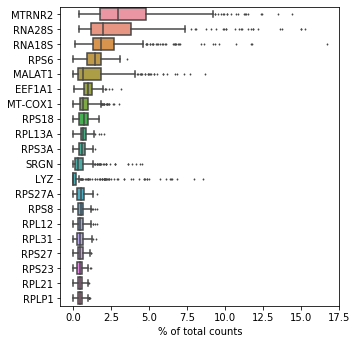

In [50]:
anndata.raw = anndata
sc.pl.highest_expr_genes(anndata, n_top=20, )

In [51]:
anndata.shape

(328, 27899)

In [52]:
# Normalization and filtering
sc.pp.filter_genes(anndata, min_cells=200)

In [34]:
anndata.shape

(328, 4)

In [53]:
sc.pp.normalize_total(anndata, target_sum=1e4)
sc.pp.log1p(anndata)

In [54]:
np.max(anndata.raw.X)
np.max(anndata.X)

8.06658

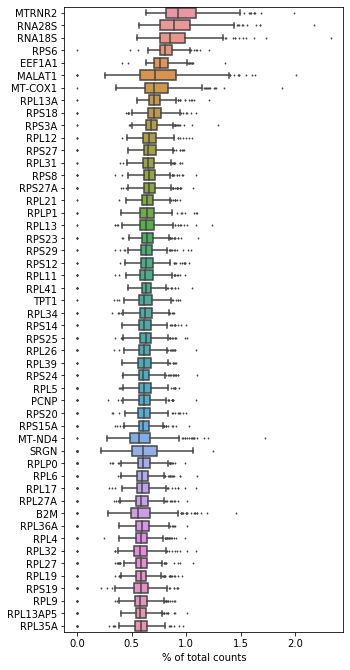

In [55]:
sc.pl.highest_expr_genes(anndata, n_top=50, )

## Machine Learning

In [56]:
barcodes2class = dict(zip(anno.Cell,
                          anno.PredictionRefined))
y_true = [barcodes2class[x] for x in anndata.obs_names]
X = anndata.X
X_train = X
classdict = dict(normal=0, malignant=1)
y_true_num = [classdict[x] for x in y_true]
y_train = np.array(y_true_num)

POP on training set

In [57]:
# POP on the training set
from pop_implemetation import *

(mind_train, maxd_train, isborder_train, attr2outerb_train, attr2innerb_train,
 attr2outerb_train_val, attr2innerb_train_val) = pop_instance_training(X_train, y_train)
train_border_examples = X_train[np.argwhere(np.sum(np.abs(isborder_train), axis=1)!=0).ravel(),:]
ytrain_border_examples = y_train[np.argwhere(np.sum(np.abs(isborder_train), axis=1)!=0).ravel()]

In [58]:
mind_train
maxd_train

array([6.11584234, 4.34564972, 4.5389514 , 5.50460386, 5.20398188,
       4.48115063, 4.00478363, 4.28789854, 4.60772276, 4.94587564,
       4.50740433, 4.87259579, 3.81524944, 5.78213167, 4.65849876,
       4.28825283, 4.77421093, 5.09670019, 4.31555605, 4.80275726,
       5.05396318, 4.44720793, 4.70294571, 3.82522368, 4.60526896,
       4.88863039, 4.62079477, 4.46721888, 4.28084135, 4.14142084,
       4.28730822, 4.50740385, 4.90032434, 3.97698689, 3.82045698,
       4.93599367, 4.31264591, 4.92715454, 4.33413172, 4.28789854,
       4.64426231, 4.28084135, 4.10596848, 4.48010874, 4.71290541,
       4.20804787, 4.29203892, 6.17586708, 4.47684288, 4.58778238,
       4.48721361, 4.87259579, 4.5695219 , 5.54169703, 6.92796707,
       4.13125086, 5.59477329, 5.12672281, 4.57060242, 4.81684065,
       5.61842299, 3.97570324, 4.81027699, 4.78253698, 5.00985765,
       4.17386246, 4.51631451, 4.48692417, 5.83514118, 4.05916643,
       4.28789854, 5.12751579, 4.89074612, 5.60708332, 4.19723

In [60]:
clf_svm = SVC()
scores_svm = cross_validate(clf_svm, X_train, 
                        y_train, 
                        scoring={'accuracy_score':make_scorer(accuracy_score),
                                 'precision_score':make_scorer(precision_score),
                                 'prc':make_scorer(average_precision_score),
                                 'mcc':make_scorer(matthews_corrcoef)})
from sklearn.linear_model import LogisticRegression
clf_lr =  LogisticRegression(penalty='l1', solver='liblinear') # Lasso
scores_lr = cross_validate(clf_lr, X_train, 
                        y_train, 
                        scoring={'accuracy_score':make_scorer(accuracy_score),
                                 'precision_score':make_scorer(precision_score),
                                 'prc':make_scorer(average_precision_score),
                                 'mcc':make_scorer(matthews_corrcoef)})

                                    

In [61]:
# Training on the entire training set
clf_svm.fit(X_train, y_train)
clf_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [62]:
scores_svm

{'fit_time': array([0.02625775, 0.01929498, 0.01761985, 0.01382494, 0.01474977]),
 'score_time': array([0.00651717, 0.00921583, 0.01131225, 0.00443506, 0.00461602]),
 'test_accuracy_score': array([0.86363636, 0.75757576, 0.8030303 , 0.89230769, 0.76923077]),
 'test_precision_score': array([0.875     , 0.80701754, 0.80645161, 0.87719298, 0.84313725]),
 'test_prc': array([0.8709893 , 0.80365575, 0.80579035, 0.87719298, 0.83279035]),
 'test_mcc': array([0.57752005, 0.20592084, 0.31682725, 0.68398557, 0.33480069])}

In [63]:
scores_lr

{'fit_time': array([0.02374887, 0.03087902, 0.04360509, 0.03957486, 0.03892088]),
 'score_time': array([0.00216317, 0.0023098 , 0.00203395, 0.00214624, 0.00697994]),
 'test_accuracy_score': array([0.77272727, 0.71212121, 0.75757576, 0.75384615, 0.70769231]),
 'test_precision_score': array([0.86      , 0.80769231, 0.81818182, 0.84      , 0.82978723]),
 'test_prc': array([0.84631016, 0.80152201, 0.81283422, 0.82867692, 0.81646481]),
 'test_mcc': array([0.36814319, 0.16079955, 0.24253563, 0.30666667, 0.2322501 ])}

In [64]:
[np.mean(scores_svm[x]) for x in scores_svm.keys() ]

[0.018349456787109374,
 0.007219266891479492,
 0.8171561771561772,
 0.8417598788241951,
 0.8380837476160556,
 0.42381088155727065]

In [65]:
[np.mean(scores_lr[x]) for x in scores_lr.keys() ]

[0.03534574508666992,
 0.0031266212463378906,
 0.7407925407925408,
 0.8311322719833358,
 0.8211616254583964,
 0.2620790285853663]

### Predicting on a Validation dataset
We try to predict the class of new unseen examples

*Obs*: first of all we need to correct for batch effect
